# Modeling: K-Means positives cases

Finally, the product of this analysis is here: clustering provinces in terms of infections and population. The process is as follows:

* Importing data
* Applying PCA so as to reduce dimensionality, we need relevant variables to save computational power
* Scaling the data
* Finding the optimal K clusters
* Applying K-Means algorithm


In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Machine learning libs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

## Importing dataset

In [4]:
positives_provinces = pd.read_csv('/work/covid-19-EC-provinces/data/interim/positives_provinces.csv')

### Visualization

It's a good idea to visualize our data again.

In [5]:
sns.set_theme()

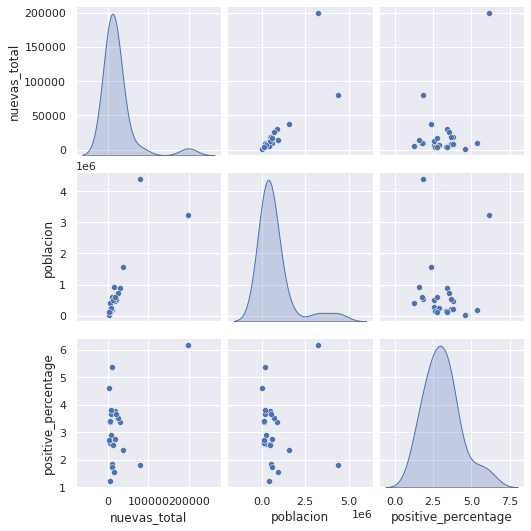

In [6]:
sns.pairplot(positives_provinces, diag_kind='kde')
plt.show()

## Dimensionality reduction: PCA

We have 3 variables and we could cluster our data in a 3D representation. But, is that really necessary? Can we reduce variables? Te answer is **yes** and the model used here is PCA. Then, we need to find the most relevant variables to maximize the information we get.

Lest begin by scaling data.

In [7]:
scaler = StandardScaler()
scaled = scaler.fit_transform(
    positives_provinces[['nuevas_total', 'positive_percentage', 'poblacion']].values)

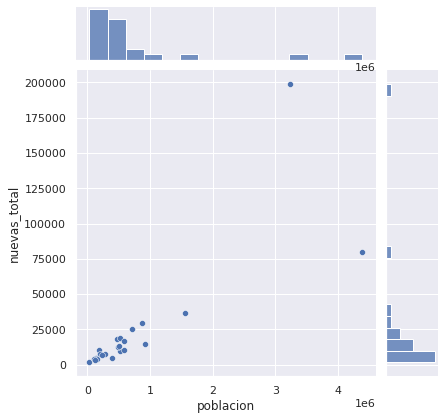

In [8]:
sns.jointplot(x=positives_provinces['poblacion'], y=positives_provinces['nuevas_total'])
plt.show()

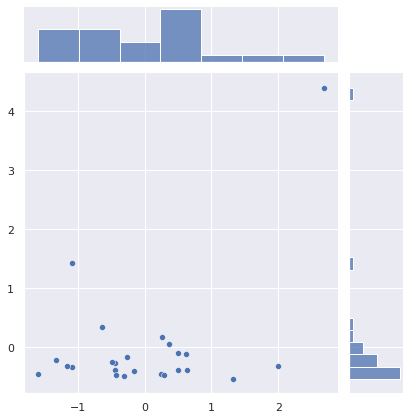

In [9]:
sns.jointplot(x=scaled[:, 1], y=scaled[:, 0])
plt.show()

We need the covariance matrix so as to get its eigenvalues and eigenvectors and find the most relevant values.

In [10]:
#covariance matrix
covariance_matrix = positives_provinces.corr()

In [11]:
covariance_matrix

,nuevas_total,poblacion,positive_percentage
nuevas_total,1.000000,0.806735,0.437515
poblacion,0.806735,1.000000,0.026237
positive_percentage,0.437515,0.026237,1.000000


In [12]:
#Eigenvalues and eigenvectors
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

In [13]:
eigen_values

array([1.92890675, 0.09307833, 0.97801491])

In [14]:
eigen_vectors

array([[ 0.70277646,  0.71123946, -0.01560994],
       [ 0.62019005, -0.62326505, -0.47634544],
       [ 0.3485248 , -0.32508323,  0.87911965]])

In [15]:
#Finding the most relevant PCs
variance_explained = []

for i in eigen_values:
    variance_explained.append(i/sum(eigen_values)*100)

variance_explained

[64.29689178741174, 3.1026111453953296, 32.60049706719293]

In [16]:
#Checking:
novic = eigen_values/(len(positives_provinces['nuevas_total'])-1)

variance_explained2 = []
for i in novic:
    variance_explained2.append(i/sum(novic)*100)
variance_explained2

[64.29689178741174, 3.102611145395329, 32.60049706719294]

PCs 1 and 3 are the most relevant ones.

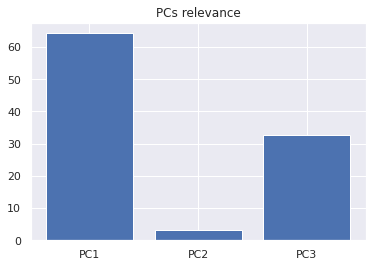

In [17]:
fig, ax = plt.subplots()
plt.bar(['PC1', 'PC2', 'PC3'], variance_explained)
plt.title('PCs relevance')
plt.show()

I'll try with those 2.

In [18]:
pca = PCA(n_components=2)
pca.fit(scaled)

PCA(n_components=2)

In [19]:
pca.explained_variance_ratio_

array([0.64296892, 0.32600497])

So, we get about 97% of variance.

In [20]:
reduced_scaled = pca.transform(scaled)

In [21]:
positives_provinces['pca_1'] = reduced_scaled[:, 0]
positives_provinces['pca_2'] = reduced_scaled[:, 1]

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


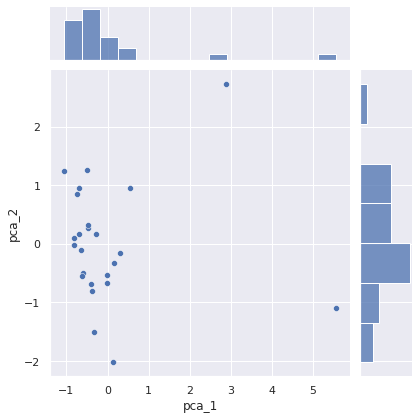

In [22]:
sns.jointplot(positives_provinces.pca_1, positives_provinces.pca_2)

## Finding clusters in data: K-Means

Now that we found PC1 and PC2, it's time to cluster the data.

In [23]:
positives_provinces

,provincia,nuevas_total,poblacion,positive_percentage,pca_1,pca_2
0,Azuay,29776,881394,3.378285,0.310205,-0.153536
1,Bolívar,7670,209933,3.653547,-0.410645,-0.692405
2,Carchi,10056,186869,5.381310,0.140316,-2.022739
3,Cañar,7245,281396,2.574663,-0.700612,0.165909
4,Chimborazo,9579,524004,1.828039,-0.735368,0.852942
5,Cotopaxi,12521,488716,2.562020,-0.483302,0.276403
6,El Oro,25088,715751,3.505130,0.163658,-0.331211
7,Esmeraldas,10312,591083,1.744594,-0.706181,0.948952
8,Galápagos,1523,33042,4.609285,-0.338649,-1.509409
9,Guayas,79925,4387434,1.821680,2.893075,2.725925


In [24]:
x = positives_provinces[['pca_1', 'pca_2']]

### Finding the optimal K clusters

I'll use the elbow method for optimal K.

Text(0, 0.5, 'Inertia')

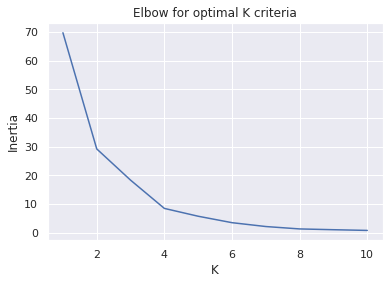

In [25]:
#Elbow for optimal K criteria

inertia = []

for i in range(1, 11):
    model = KMeans(n_clusters=i, max_iter=1000, random_state=0)
    model.fit(x)
    inertia.append(model.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow for optimal K criteria')
plt.xlabel('K')
plt.ylabel('Inertia')

As the plot shows, the optimal K is between 2 and 4. I'm iterating.

In [26]:
model = KMeans(n_clusters=4, max_iter=1000)
model.fit(x)

KMeans(max_iter=1000, n_clusters=4)

In [27]:
clusters = model.predict(x)

<AxesSubplot:xlabel='pca_1', ylabel='pca_2'>

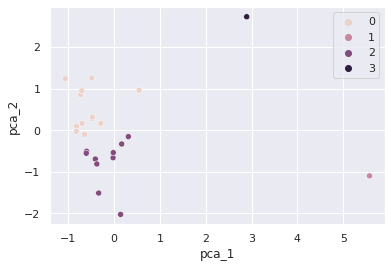

In [28]:
fig, ax = plt.subplots()
sns.scatterplot(data=positives_provinces, x='pca_1', y='pca_2', c=clusters, ax=ax, hue=clusters)

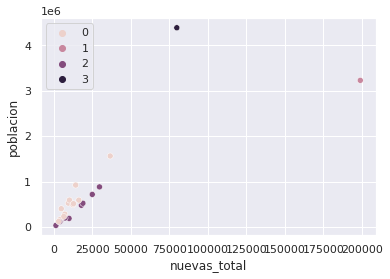

In [29]:
fig, ax = plt.subplots()
sns.scatterplot(data=positives_provinces, x='nuevas_total', y='poblacion', c=clusters, ax=ax, hue=clusters)
plt.show()

In [30]:
positives_provinces['clusters'] = clusters

In [31]:
positives_provinces[['provincia', 'clusters']].sort_values(by='clusters')

,provincia,clusters
23,Zamora Chinchipe,0
21,Sucumbíos,0
20,Sto. Domingo Tsáchilas,0
3,Cañar,0
4,Chimborazo,0
5,Cotopaxi,0
19,Santa Elena,0
7,Esmeraldas,0
16,Orellana,0
22,Tungurahua,0


![](https://i.ibb.co/qkbrLv8/ecuador-Covid-Clusters.png)

**Conclusions**

There're 4 groups of provinces when we consider the infections and population. This could help authorities take better decisions and apply policies to those specific groups. Furthermore, more investigation can be done with this groups.

Used this as a reference: https://repository.unpak.ac.id/tukangna/repo/file/files-20210615183611.pdf

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7294ef23-3287-47ac-a12f-ba892bffdf3b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>